In [8]:
#Libraries - all required except plt (just for checking and visualization) and mp (for viewing final model)
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr
import meshio
import meshplot as mp
import json
import subprocess
import colorsys

In [9]:
#Helper function for solve() - determines if a float is between two other floats
def is_between(num, n1, n2):
    if (num <= n1 and num >= n2) or (num >= n1 and num <= n2):
        return True
    else:
        return False

    
#function that determines if a point is between two other points on the same segment
def solve(coordinates) -> bool:
    (x0, y0), (x2, y2) = coordinates[0], coordinates[2]
    x1, y1 = coordinates[1]
    if (abs((x0 - x2) * (y2 - y1) - (x2 - x1) * (y0 - y2)) < 0.001) and (is_between(x1, x0, x2) and is_between(y1, y0, y2)):
        return True
    else:
        return False


#Forms lists necessary for further work - inefficient, probably needs some fixing
#This function is specifically for if you're NOT doing dual-side colours
def build_point_lists(v, pts, seg0):
    segment_lines = []
    all_dots = []
    all_dots_indexed = {}
    red_dots = []
    green_dots = []
    segment_green_points = {}
    
    for line in seg0:
        segment_lines.append([v[line[0]], v[line[1]]])

    red_dots = pts
    for d_i in range(len(red_dots)):
        all_dots_indexed[d_i] = red_dots[d_i]

    for p_i in range(len(v)):
        if v[p_i].tolist() not in red_dots:
            for l_i in range(len(seg0)):
                if solve([v[seg0[l_i][0]], v[p_i], v[seg0[l_i][1]]]):
                    green_dots.append(v[p_i].tolist())
                    all_dots_indexed[p_i] = v[p_i].tolist()
                    
    all_dots += red_dots
    all_dots += green_dots
    
    for line_index in range(len(segment_lines)):
        for p_i in range(len(green_dots)):
            if solve([segment_lines[line_index][0], green_dots[p_i], segment_lines[line_index][1]]):
                if line_index in segment_green_points:
                    segment_green_points[line_index].append((green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots)))
                else:
                    segment_green_points[line_index] = [(green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots))]
    
    return (segment_lines, all_dots, all_dots_indexed, red_dots, green_dots, segment_green_points)


#Generate RANDOM rgb values for manually plotted points (red_dots)
def random_seg_colours(seg_start, segment_lines, loop_backs, iso_segs):
    rgb_segs = []
    random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour1 == (0, 0, 0) or random_colour1 == (1, 1, 1):
        random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour2 == (0, 0, 0) or random_colour2 == (1, 1, 1):
        random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    segm = [(segment_lines[seg_start][0][0], segment_lines[seg_start][0][1]), (segment_lines[seg_start][1][0], segment_lines[seg_start][1][1])]
    rgb_segs.append({"segment": segm, "colours": [random_colour1, random_colour2]})

    for segment_index in range(seg_start+1, len(segment_lines)):
        random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        while random_colour == (0, 0, 0) or random_colour == (1, 1, 1):
            random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        segm = [(segment_lines[segment_index][0][0], segment_lines[segment_index][0][1]), (segment_lines[segment_index][1][0], segment_lines[segment_index][1][1])]
        rgb_segs.append({"segment": segm, "colours": [rgb_segs[segment_index - (seg_start + 1)]["colours"][1], random_colour]})
    
    if len(loop_backs) > 0:
        i = 0
        while i < len(loop_backs) and loop_backs[i] < seg_start:
            i += 1
        if i < len(loop_backs):
            rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
            for loop_num_i in range(1, len(loop_backs)):
                rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]
    return rgb_segs


#Generate MANUALLY PLOTTED rgb values for manually plotted points (red_dots)
def fixed_seg_colours(cols, seg_start, segment_lines, loop_backs, iso_segs):
    rgb_segs = []
    segm = [(segment_lines[seg_start][0][0], segment_lines[seg_start][0][1]), (segment_lines[seg_start][1][0], segment_lines[seg_start][1][1])]
    rgb_segs.append({"segment": segm, "colours": [cols[0], cols[1]]})

    for i in range(seg_start + 1, len(segment_lines)):
        segm = [(segment_lines[i][0][0], segment_lines[i][0][1]), (segment_lines[i][1][0], segment_lines[i][1][1])]
        rgb_segs.append({"segment": segm, "colours": [cols[i - (seg_start+1)], cols[i - seg_start]]})
        
    rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
    for loop_num_i in range(1, len(loop_backs)):
        rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]
    return rgb_segs


#Function converts mesh into HSV interpolation - do not run if you want to do RGB interpolation
def hsv_interpolation(rgb_segs):
    rgb_s = rgb_segs
    for seg in rgb_s:
        col1 = seg['colours'][0]
        col2 = seg['colours'][1]
        seg['colours'] = []
        seg['colours'].append(colorsys.rgb_to_hsv(col1[0], col1[1], col1[2]))
        seg['colours'].append(colorsys.rgb_to_hsv(col2[0], col2[1], col2[2]))
    return rgb_s


#Takes colours from rgb_segs and maps individual points - inefficient, could find way to do this without rgb_points AND rgb_segs
def point_seg_align(rgb_p, rgb_segs, seg_start, iso_segs, red_dots):
    rgb_points = rgb_p
    i = 0
    while i < len(iso_segs) and iso_segs[i] < seg_start:
        i += 1
    if i < len(iso_segs):
        iso_count = 0
        for point_index in range(len(rgb_segs)):
            col = rgb_segs[point_index]['colours'][0]
            rgb_points[point_index + iso_count] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}
            if point_index in iso_segs[i:]:
                col = rgb_segs[point_index]['colours'][1]
                iso_count += 1
                rgb_points[point_index + iso_count] = {"point": (red_dots[point_index + seg_start + iso_count][0], red_dots[point_index + seg_start + iso_count][1]), "colour": col}
    else:
        for point_index in range(seg_start, len(red_dots)):
            col = rgb_segs[point_index]['colours'][0]
            rgb_points[point_index] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}
    return rgb_points


#Take colour values of red_dots and figure out what the dots on those segments should be coloured
def interpolate_points(rgb_p, rgb_segs, segment_green_points, segment_lines, point_start, seg_start):
    rgb_points = rgb_p
    for seg in segment_green_points:
        for point in segment_green_points[seg]:
            line = segment_lines[seg]
            line_height = abs(line[0][1] - line[1][1])
            line_width = abs(line[0][0] - line[1][0])
            rel_height = abs(point[1] - line[0][1])
            rel_width = abs(point[0] - line[0][0])
            ratio = max(rel_height, rel_width) / max(line_height, line_width)

            start_r, start_g, start_b = rgb_segs[seg - seg_start]["colours"][0]
            end_r, end_g, end_b = rgb_segs[seg - seg_start]["colours"][1]

            r = ((end_r - start_r) * ratio) + start_r
            g = ((end_g - start_g) * ratio) + start_g
            b = ((end_b - start_b) * ratio) + start_b
            
            if r < 0:
                r = 0
            elif r > 1:
                r = 1
            if g < 0:
                g = 0
            elif g > 1:
                g = 1
            if b < 0:
                b = 0
            elif b > 1:
                b = 1

            pnt_obj = {"point": (point[0], point[1]), "colour": (r, g, b)}
            rgb_points[point[2] - point_start] = pnt_obj
    return rgb_points

In [10]:
def build_segments(tri_out:tuple, left_list:list=[], useHsv:bool=False):
    pts = tri_out[0].tolist()
    seg0 = tri_out[1].tolist()
    meshObj = tri_out[2]
    loop_backs = tri_out[3]
    iso_segs = tri_out[4]
    
    v = meshObj['vertices']
    
    lists = build_point_lists(v, pts, seg0)
    segment_lines = lists[0]
    all_dots = lists[1]
    all_dots_indexed = lists[2]
    red_dots = lists[3]
    green_dots = lists[4]
    segment_green_points = lists[5]
    
    rgb_segs = []

    if len(left_list) > 0:
        rgb_segs = fixed_seg_colours(left_list, 0, segment_lines, loop_backs, iso_segs)
    else:
        rgb_segs = random_seg_colours(0, segment_lines, loop_backs, iso_segs)
    
    if useHsv:
        rgb_segs = hsv_interpolation(rgb_segs)

    rgb_points = []
    
    for i in range(len(all_dots)):
        rgb_points.append(None)
    
    rgb_points = point_seg_align(rgb_points, rgb_segs, 0, iso_segs, red_dots)
    
    rgb_points = interpolate_points(rgb_points, rgb_segs, segment_green_points, segment_lines, 0, 0)
    
    return (rgb_points, useHsv, all_dots_indexed, meshObj)

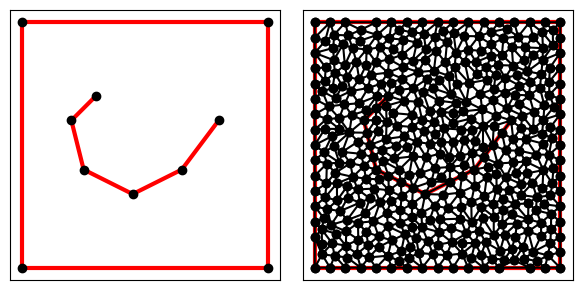

In [11]:
#Forming the object (manually)
pts0 = np.array(((0, 0), (10, 0), (10, 10), (0, 10))) #border
pts1 = np.array(((3, 7), (2, 6), (2.5, 4), (4.5, 3), (6.5, 4), (8, 6)))

pts = np.vstack([pts0, pts1]) #combined

#connecting points together (manually)
seg1 = np.array(((0, 1), (1, 2), (2, 3), (3, 0)))
seg2 = []
for i in range(4, len(pts1) + 3):
    seg2.append((i, i+1))
seg2 = np.array(seg2)
seg_comb = [seg1, seg2]
seg0 = np.vstack(seg_comb)

#indicies where segment meets up with beginning of shape--needed for random colour generation, but not manual
loop_backs = [3]
#indicies where segments are isolated
iso_segs = [8]

A = dict(vertices=pts, segments=seg0)
meshObj = tr.triangulate(A, 'qpa0.2')

shape = (pts, seg0, meshObj, loop_backs, iso_segs)

tr.compare(plt, A, meshObj)

In [12]:
segments = build_segments(shape)
rgb_points = segments[0]
isHsv = segments[1]
all_dots_indexed = segments[2]
meshObj = segments[3]

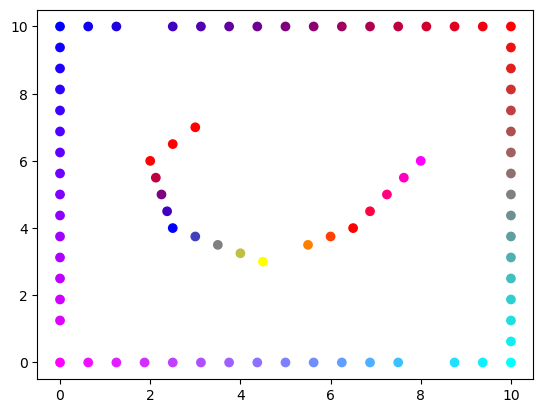

In [13]:
#plot segment lines using data gathered!
plot_x = []
plot_y = []
co = []
for i in rgb_points:
    plot_x.append(i['point'][0])
    plot_y.append(i['point'][1])
    colr = ()
    if isHsv:
        colr = colorsys.hsv_to_rgb(i['colour'][0], i['colour'][1], i['colour'][2])
    else:
        colr = (i['colour'][0], i['colour'][1], i['colour'][2])
    co.append(colr)

plt.scatter(plot_x, plot_y, c=co)

In [57]:
count = 0
#Write vertex-colour data onto txt files
vertex_reds = open("vertex_reds.txt", "w")
for point_i in all_dots_indexed:
    vertex_reds.write(f"{point_i} {rgb_points[count]['colour'][0]}\n")
    count += 1
vertex_reds.close()

count = 0
vertex_greens = open("vertex_greens.txt", "w")
for point_i in all_dots_indexed:
    vertex_greens.write(f"{point_i} {rgb_points[count]['colour'][1]}\n")
    count += 1
vertex_greens.close()

count = 0
vertex_blues = open("vertex_blues.txt", "w")
for point_i in all_dots_indexed:
    vertex_blues.write(f"{point_i} {rgb_points[count]['colour'][2]}\n")
    count += 1
vertex_blues.close()


#Write mesh generated by triangle onto obj file
obj = open("meshObj.obj", "w")
for point in meshObj['vertices']:
    obj.write(f'v {point[0]} {point[1]}  0\n')
obj.write('\n\n\n\n\n\n')
for triangle in meshObj['triangles']:
    obj.write(f'f {triangle[0] + 1} {triangle[1] + 1} {triangle[2] + 1}\n')
obj.close()

#Set up problems for PolyFEM
reds = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_reds.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "red.vtu"
        }
    }
}

greens = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_greens.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "green.vtu"
        }
    }
}

blues = {
    "geometry": {
        "mesh": "meshObj.obj"
    },
    "materials": {
        "type": "Laplacian"
    },
    "boundary_conditions": {
        "dirichlet_boundary": [
            "vertex_blues.txt"
        ]
    },
    "output": {
        "paraview": {
            "file_name": "blue.vtu"
        }
    }
}


#Dump problems into readable json files
with open("red.json", "w") as fp:
    json.dump(reds, fp)
    
with open("green.json", "w") as fp:
    json.dump(greens, fp)
    
with open("blue.json", "w") as fp:
    json.dump(blues, fp)


#Generate red map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "red.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#Generate green map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "green.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

#Generate blue map for object
command = ["C:\\polyfem\\out\\build\\x64-Debug\\PolyFEM_bin.exe","-j", "blue.json"]
p = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [58]:
#Read files generated by PolyFEM
red = meshio.read("red.vtu")
green = meshio.read("green.vtu")
blue = meshio.read("blue.vtu")


#Use reordered faces from one of the files generated by PolyFEM (they're all ordered the same)
face_list = red.cells_dict['triangle']


#Grab generated RGB values and compile into a colour array (co), then convert to mp-readable array with numpy
co = []
for i in range(len(red.points)):
    colr = ()
    if isHsv:
        colr = colorsys.hsv_to_rgb(red.point_data['solution'][i][0], green.point_data['solution'][i][0], blue.point_data['solution'][i][0])
    else:
        colr = (red.point_data['solution'][i][0], green.point_data['solution'][i][0], blue.point_data['solution'][i][0])
    co.append(colr)
col = np.array(co)

In [59]:
#Generate 3D object!
mp.plot(red.points, face_list, c=col, return_plot=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, 5.0,…